In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

import pickle
import warnings
warnings.filterwarnings("ignore")

import time

In [2]:
# Getting the data
customer_data_df = pd.read_csv("../Data/pre_processed_data_1.csv", sep = "\t")
customer_data_df.head(10)

,Income,Response,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate
0,58138.0,1,0,1617,1,25,65,3668,0.0,1.0,0.0,1.0,0.0
1,46344.0,0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0
2,71613.0,0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0
3,26646.0,0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0
4,58293.0,0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0
5,62513.0,0,1,716,0,22,55,3150,1.0,0.0,0.0,1.0,0.0
6,55635.0,0,1,590,0,21,51,3450,0.0,1.0,0.0,1.0,0.0
7,33454.0,0,1,169,0,10,37,3185,1.0,0.0,0.0,1.0,0.0
8,30351.0,1,1,46,1,6,48,3245,1.0,0.0,0.0,1.0,0.0
9,5648.0,0,2,49,1,2,72,2965,1.0,0.0,0.0,1.0,0.0


In [3]:
# Getting the labels and the data separately.
customer_data_X = customer_data_df.drop(columns = ["Response"])
customer_data_Y = customer_data_df["Response"]

In [4]:
customer_data_X

,Income,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate
0,58138.0,0,1617,1,25,65,3668,0.0,1.0,0.0,1.0,0.0
1,46344.0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0
2,71613.0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0
3,26646.0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0
4,58293.0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2235,61223.0,1,1341,0,18,55,3238,1.0,0.0,0.0,1.0,0.0
2236,64014.0,3,444,1,22,76,2758,1.0,0.0,0.0,1.0,0.0
2237,56981.0,0,1241,1,19,41,3012,0.0,1.0,0.0,1.0,0.0
2238,69245.0,1,843,0,23,66,3013,1.0,0.0,0.0,1.0,0.0


In [5]:
customer_data_Y

0       1
1       0
2       0
3       0
4       0
       ..
2235    0
2236    0
2237    0
2238    0
2239    1
Name: Response, Length: 2240, dtype: int64

In [6]:
# Split the dataset
X_dev, X_test, y_dev, y_test = train_test_split(customer_data_X,
                                                customer_data_Y, 
                                                stratify = customer_data_Y,
                                                test_size = 0.2,
                                                random_state = 42)

print(f"The shape of the Development Set Features: {X_dev.shape}")
print(f"The shape of the Testing Set Features: {X_test.shape}")
print(f"The shape of the Development Set Labels: {y_dev.shape}")
print(f"The shape of the Testing Set Labels: {y_test.shape}")

The shape of the Development Set Features: (1792, 12)
The shape of the Testing Set Features: (448, 12)
The shape of the Development Set Labels: (1792,)
The shape of the Testing Set Labels: (448,)


In [7]:
# Just for Fun!
test_clf = XGBClassifier(random_state = 2102)
test_clf.fit(X_dev, y_dev)

print(f"Score on Dev Data: {test_clf.score(X_dev, y_dev)}")
print(f"Score on Test Data: {test_clf.score(X_test, y_test)}")

Score on Dev Data: 1.0
Score on Test Data: 0.9263392857142857


In [8]:
# Now we will try and do hyperparameter search, let's see how do the results look like!

In [9]:
# XGBoost Classifier
# Setting the grid for hyperparameter tuning for GridSearchCV
param_grid = {
    'eta': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_depth': [4, 6, 8, 9, 10],
    'gamma': [0, 3, 7]
}

pipe = make_pipeline(GridSearchCV(XGBClassifier(random_state = 42), \
                                  param_grid = param_grid, \
                                  scoring = 'f1', \
                                  refit = 'f1',\
                                  cv = 5,
                                  return_train_score = True, \
                                  verbose = 2))

print("For XGBoost Classifier:")
begin_time = time.time()
pipe.fit(X_dev, y_dev)
end_time = time.time()
print(f"Total time taken for model selection and training the model is: {(end_time - begin_time)/60} minutes.")

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_lr = grid_search_results.best_params_['eta']
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_gamma = grid_search_results.best_params_['gamma']

print(f"Best value of hyperparameter eta is: {grid_search_result_lr}")
print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter gamma is: {grid_search_result_gamma}")
print(f"F-1 Score for Testing Data: {pipe.score(X_test, y_test)}")

For XGBoost Classifier:
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   1.8s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   1.9s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   2.8s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   2.2s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   4.0s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   5.1s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   5.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   4.3s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   4.6s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   3.3s
[CV] END ...................eta=0.0001, gamma=0, max_depth=8; total time=   2.5s
[CV] END ..............

In [10]:
xgb_clf = XGBClassifier(eta = 0.1, max_depth = 4, gamma = 0, random_state = 42)
xgb_clf.fit(X_dev, y_dev)

y_pred = xgb_clf.predict(X_test)

print(f"Accuracy Score for Dev Data: {xgb_clf.score(X_dev, y_dev) * 100}")
print(f"Accuracy Score for Testing Data: {xgb_clf.score(X_test, y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(y_test, y_pred)}")

Accuracy Score for Dev Data: 97.93526785714286
Accuracy Score for Testing Data: 93.08035714285714
F-1 Score for Testing Data: 0.7596899224806203


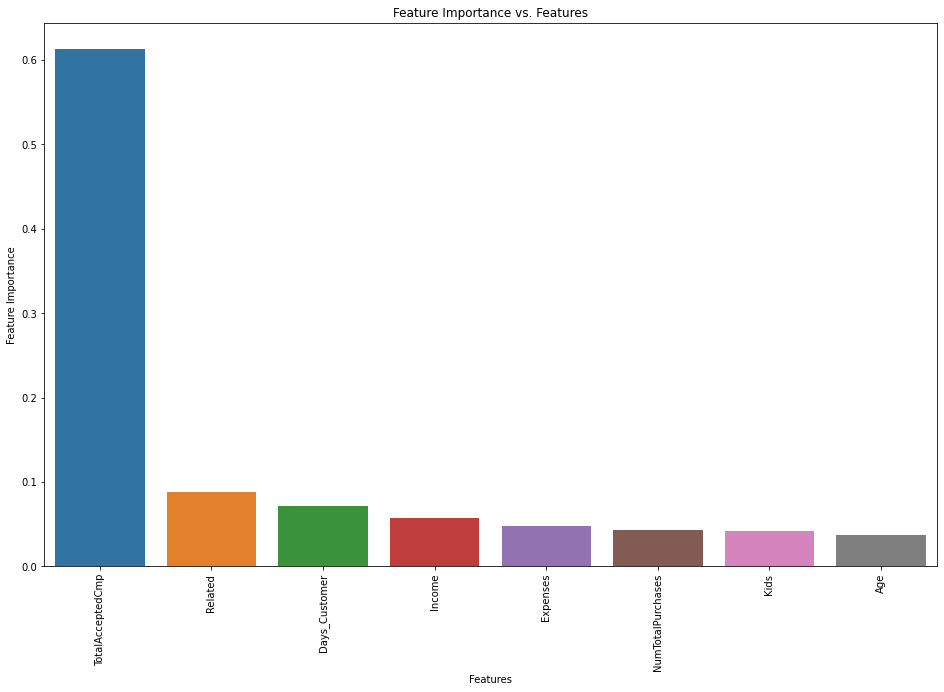

In [11]:
# Let's look at the Feature Importances!
feature_names = list(X_dev.columns)
feature_importances = xgb_clf.feature_importances_
feature_importances_map = zip(feature_names, feature_importances)
sorted_feat_names, sorted_feat_importances = zip(*(sorted(list\
                                                    (filter(lambda x: x[1] != 0, feature_importances_map)),\
                                                    key = lambda x: x[1], reverse = True)))

fig = plt.figure(figsize = (16,10))
ax = sns.barplot(list(sorted_feat_names), list(sorted_feat_importances))
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
ax.set_title("Feature Importance vs. Features")
ax.tick_params(axis = 'x', rotation = 90)

In [12]:
model_name_saved = "../SavedModels/XGBoostClf.pkl"
with open(model_name_saved, 'wb') as file:
    pickle.dump(xgb_clf, file)

In [13]:
# Now, let's try and take just the top most 3 important features and try and run the model again!

top_3_features = list(sorted_feat_names[:3])
# XGBoost Classifier
# Setting the grid for hyperparameter tuning for GridSearchCV
param_grid = {
    'eta': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_depth': [4, 6, 8, 9, 10],
    'gamma': [0, 3, 7]
}

pipe = make_pipeline(GridSearchCV(XGBClassifier(random_state = 42), \
                                  param_grid = param_grid, \
                                  scoring = 'f1', \
                                  refit = 'f1',\
                                  cv = 5, \
                                  return_train_score = True, \
                                  verbose = 2))

print("For XGBoost Classifier:")
begin_time = time.time()
pipe.fit(X_dev[top_3_features], y_dev)
end_time = time.time()
print(f"Total time taken for model selection and training the model is: {(end_time - begin_time)/60} minutes.")

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_lr = grid_search_results.best_params_['eta']
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_gamma = grid_search_results.best_params_['gamma']

print(f"Best value of hyperparameter eta is: {grid_search_result_lr}")
print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter gamma is: {grid_search_result_gamma}")
print(f"F-1 Score for Testing Data: {pipe.score(X_test[top_3_features], y_test)}")

For XGBoost Classifier:
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=4; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=6; total time=   0.4s
[CV] END ...................eta=0.0001, gamma=0, max_depth=8; total time=   0.4s
[CV] END ..............

As we can see above, after we take only the top 4 features, our accuracy goes down, not by a lot though but this model might generalize better than the previous one. But, as we saw the feature importances above, none of them was very unimportant so, I will not throw away any features here.

In [14]:
# As our dataset is not highly imbalanced, but a little skewed, Stratified sampling helped us here.
# We could do some kind of sampling technique as well but our model performs pretty good even without any
# kind of sampling involved.

# Also our model doesn't overfit as we pass the parameter for early stopping the training and thus, we get more
# stable model with comparable accuracy scores for development data and testing data.

# Now let's see how the confusion matrix looks like!

In [15]:
xgb_clf = XGBClassifier(eta = 0.1, max_depth = 4, gamma = 0, random_state = 42)
xgb_clf.fit(X_dev, y_dev)

y_pred = xgb_clf.predict(X_test)

print(f"Accuracy Score for Dev Data: {xgb_clf.score(X_dev, y_dev) * 100}")
print(f"Accuracy Score for Testing Data: {xgb_clf.score(X_test, y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(y_test, y_pred)}")

Accuracy Score for Dev Data: 97.93526785714286
Accuracy Score for Testing Data: 93.08035714285714
F-1 Score for Testing Data: 0.7596899224806203


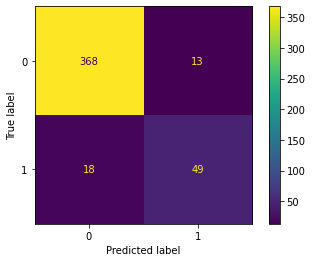

In [16]:
plot_confusion_matrix(xgb_clf, X_test, y_test)
plt.show()

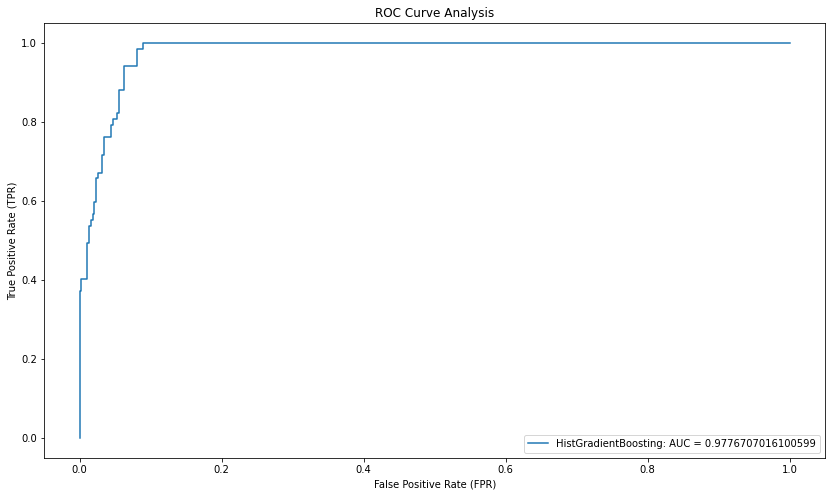

In [17]:
# Making predictions and plotting the ROC
fig = plt.figure(figsize = (14, 8))

y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label = 1)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = f"HistGradientBoosting: AUC = {auc_score}")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Analysis")
plt.legend(loc = "lower right")
plt.show()

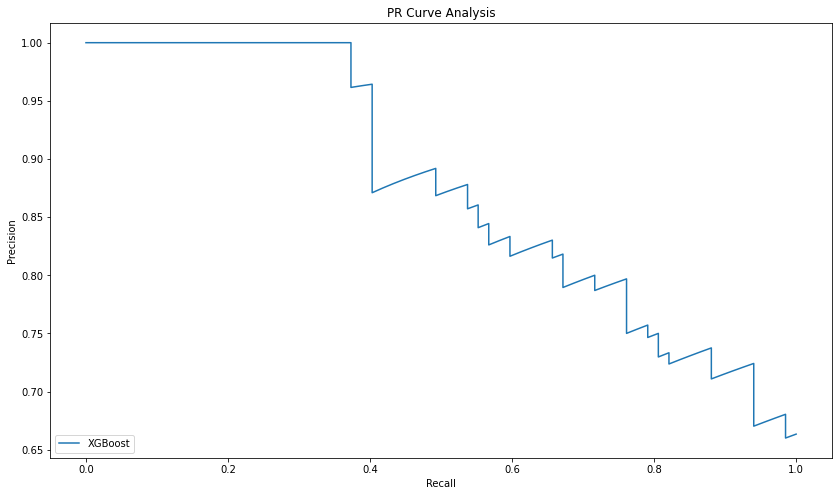

In [18]:
fig = plt.figure(figsize = (14, 8))

y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label = 1)

plt.plot(recall, precision, label = f"XGBoost")
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve Analysis")
plt.legend(loc = "lower left")
plt.show()

In [19]:
# Now, we also need to see whether Calibration would help us!

In [20]:
xgb_clf = XGBClassifier(eta = 0.0001, max_depth = 4, gamma = 0, random_state = 42)
xgb_clf.fit(X_dev, y_dev)
pred_probs = xgb_clf.predict_proba(X_test)[:, 1]

print(f"Brier Score for Optimal XGBoost Classifier: {brier_score_loss(y_test, pred_probs)}")

Brier Score for Optimal XGBoost Classifier: 0.24611706879490922


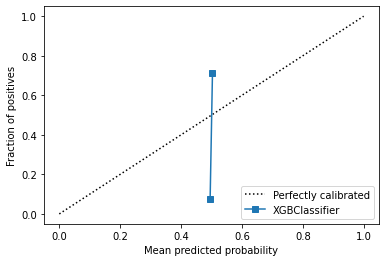

In [21]:
xgb_clf_disp = CalibrationDisplay.from_estimator(xgb_clf, X_test, y_test, n_bins = 10)
plt.show()

In [22]:
# It looks like we need to do some Calibration here!

In [23]:
# Splitting the data first
X_train, X_calib, y_train, y_calib = train_test_split(X_dev, y_dev, 
                                                      stratify = y_dev, test_size = 0.2, 
                                                      random_state = 42)

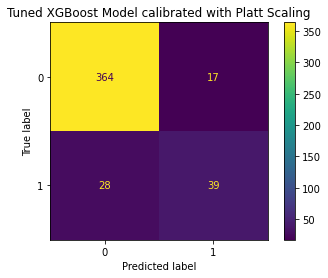

In [24]:
# Let's try Platt Scaling first!
xgb_clf = XGBClassifier(eta = 0.0001, max_depth = 4, gamma = 0, random_state = 42)
xgb_clf.fit(X_train, y_train)

xgb_platt_calib = CalibratedClassifierCV(xgb_clf, cv = "prefit", method = "sigmoid")
xgb_platt_calib.fit(X_calib, y_calib)

plot_confusion_matrix(xgb_platt_calib, X_test, y_test)
plt.title("Tuned XGBoost Model calibrated with Platt Scaling")
plt.show()

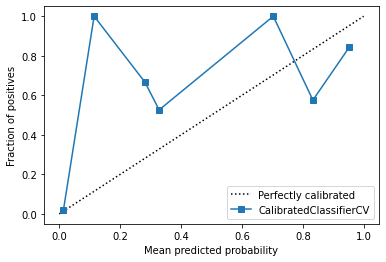

In [25]:
xgb_clf_platt_disp = CalibrationDisplay.from_estimator(xgb_platt_calib, X_test, y_test, n_bins = 10)
plt.show()

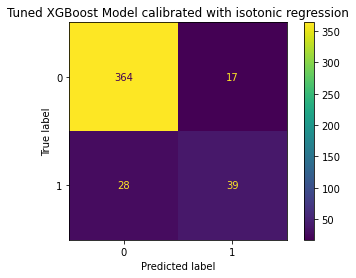

In [26]:
# let's try Isotonic now!
xgb_isotonic_calib = CalibratedClassifierCV(xgb_clf, cv = "prefit", method = "isotonic")
xgb_isotonic_calib.fit(X_calib, y_calib)

plot_confusion_matrix(xgb_isotonic_calib, X_test, y_test)
plt.title("Tuned XGBoost Model calibrated with isotonic regression")
plt.show()

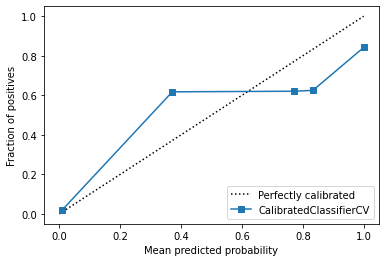

In [27]:
xgb_clf_isotonic_disp = CalibrationDisplay.from_estimator(xgb_isotonic_calib, X_test, y_test, n_bins = 10)
plt.show()

In [28]:
# Let's look at the Brier Scores!
pred_probs_hist_platt = xgb_platt_calib.predict_proba(X_test)[:, 1]
pred_probs_hist_isotonic = xgb_isotonic_calib.predict_proba(X_test)[:, 1]

print("Brier Score for Tuned XGBoost Model with Platt Scaling : ", \
      brier_score_loss(y_test, pred_probs_hist_platt))
print("Brier Score for Tuned XGBoost Model with Isotonic Regression : ", \
      brier_score_loss(y_test, pred_probs_hist_isotonic))

Brier Score for Tuned XGBoost Model with Platt Scaling :  0.07177526391487052
Brier Score for Tuned XGBoost Model with Isotonic Regression :  0.06450221230776422


In [29]:
# As can be seen above, the calibration methods have helped us a lot in this case. 
# For both the calibration methods, the brier scores have decreased which means
# that we have better calibrated prediction probabilities after the calibration
# methods.

# Also, among the 2 calibration methods, Isotonic works better than the Platt 
# Scaling. So, I would use isotonic calibration if I need to get the prediction
# probabilities for the 2 types of customer reponses. This might even help further
# in the customer behavior analysis.